This jupyter notebook use SentinelHub API program to obtain, visualize, cloud-masking, and download Sentinel-2 data

The author of this script is Boya ("Paul") Zhang email:bzhang64@ucmerced.edu

There are six sections in total

Section 1 Import packages and basic functions

Section 2 Setup configuration parameters

Section 3 Search for available Sentinel-2 data using catalog

Section 4 Request your S-2 image through the API

Excercise 1 Generate NDVI by changing the script

Section 5 Batch download time series for a given Area of Interest (AOI)

Section 6 Cloud masking using s2cloudless

Excercise 2 Change the AOI and time interval based on your study area and re-run





Lets start from Section 1 

Block 1 below shows all the required python packages
Click Run button or Shift + Enter to run it

In [1]:
### Block 1
### Section 1 Import packages and basic functions

from datetime import datetime, timedelta
import os
import sentinelhub
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import requests
import sys
#%reload_ext autoreload
#%autoreload 2
##################### SentinelHub package ##################
from sentinelhub import (
    SHConfig,
    DataCollection,
    SentinelHubCatalog,
    SentinelHubRequest,
    BBox,
    bbox_to_dimensions,
    CRS,
    MimeType,
    Geometry,
    MosaickingOrder,
    filter_times,
    generate_evalscript
)
from oauthlib.oauth2 import BackendApplicationClient
from requests_oauthlib import OAuth2Session
from s2cloudless import S2PixelCloudDetector, download_bands_and_valid_data_mask
def plot_image(image, factor=1.0, clip_range=None, **kwargs):
    """
    Utility function for plotting RGB images.
    """
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 15))
    if clip_range is not None:
        ax.imshow(np.clip(image * factor, *clip_range), **kwargs)
    else:
        ax.imshow(image * factor, **kwargs)
    ax.set_xticks([])
    ax.set_yticks([])

C:\Users\bzhang64\Anaconda3\envs\sentinel1\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


If no errors, you successfully installed all the packages
Now lets run the Section 2 (Block 2) to set up basic configuration parameters

Please change the client_id and client_secret with yours!

In [24]:
##  Block 2
## Section 2 Set up Configurations Parameters
#################### Configure SentinelHub account #########################
############ The limitation of downloading can be viewed from Copernicus dashboard ##############
############ https://shapps.dataspace.copernicus.eu/dashboard/#/ ######
############ It only allows monthly 30,000 downloads ##################
############ Registering with multiple emails/accounts is allowed ######
########### Need to try ESA Network of Resources to get more quota #####

client_id = 'REPLACE_WITH_YOURS'
client_secret = 'REPLACE_WITH_YOURS'  ## These two lines sets up the user account


###################### Configuration ###################################
config = SHConfig()
config.sh_client_id = client_id
config.sh_client_secret = client_secret
config.sh_base_url = 'https://sh.dataspace.copernicus.eu'
config.sh_token_url = 'https://identity.dataspace.copernicus.eu/auth/realms/CDSE/protocol/openid-connect/token'
#######################################################################################

client = BackendApplicationClient(client_id=client_id)
oauth = OAuth2Session(client=client)

# Get token for the session
token = oauth.fetch_token(token_url='https://identity.dataspace.copernicus.eu/auth/realms/CDSE/protocol/openid-connect/token',
                          client_secret=client_secret, include_client_id=True)

# All requests using this session will have an access token automatically added
resp = oauth.get("https://sh.dataspace.copernicus.eu/configuration/v1/wms/instances")
print(resp.content)
def sentinelhub_compliance_hook(response):
    response.raise_for_status()
    return response

oauth.register_compliance_hook("access_token_response", sentinelhub_compliance_hook)

############################# Searching parameters ############################


b'[]'


The printed message b'[]' is just a response from the server. 

If you finish without errors, congratulations! You have successfully made all installations/configuarations for SentinelHub API



Section 4

Using catalog to search for all available images within a time window and AOI

In [4]:
## Block 3
## Providing a time interval 2018 Oct 1 to 6
catalog = SentinelHubCatalog(config=config)
aoi_coords_wgs84 = [-121.699, 38.172, -121.554, 38.778]  ## full Yolo Bypass
aoi_bbox = BBox(bbox=aoi_coords_wgs84, crs=CRS.WGS84)
start_date = "2018-10-01"
end_date = "2018-10-06"
time_interval = start_date, end_date
search_iterator = catalog.search(
        DataCollection.SENTINEL2_L2A,
        bbox=aoi_bbox,
        time=time_interval,
        #filter="eo:cloud_cover < 20",
        fields={"include": ["id", "properties.datetime"], "exclude": []},
    )  ##  search how many images within this periof of 10 days
results = list(search_iterator)
dates = [item['properties']['datetime'] for item in search_iterator] ## get the dates strings

In [5]:
## Block 4
## Check the results from the query in Block 3 - two images show up!
## Note they are both Sentinel2 L2A products, same date but different tiles (SFH and SFJ)
results

[{'id': 'S2A_MSIL2A_20181002T185211_N0500_R113_T10SFH_20230620T205748.SAFE',
  'properties': {'datetime': '2018-10-02T19:03:47.866Z'}},
 {'id': 'S2A_MSIL2A_20181002T185211_N0500_R113_T10SFJ_20230620T205748.SAFE',
  'properties': {'datetime': '2018-10-02T19:03:33.533Z'}}]

In [6]:
## Block 5
## Check the corresponding dates for both results
## Notice that they have slightly different acquisition times with several seconds difference
dates

['2018-10-02T19:03:47.866Z', '2018-10-02T19:03:33.533Z']

Section 4

4a Given an Area of interest (AOI), and time interval, plot the Sentinel-2 image (Block 6 - 9)

4b Obtain an image for Yolo Bypass in north California near Sacramento (Block 10 - 14)

In [6]:
### Block 6
### Provide Area of Interest (AOI) and time interval
aoi_coords_wgs84 = [114.158084, 22.280479, 114.208714, 22.325829]  ## SWNE ## where is it?
resolution = 10
aoi_bbox = BBox(bbox=aoi_coords_wgs84, crs=CRS.WGS84)
aoi_size = bbox_to_dimensions(aoi_bbox, resolution=resolution)
catalog = SentinelHubCatalog(config=config)
start = "2024-03-01"
end = "2024-03-06"

In [8]:
### Block 7
### Obtain and visualize a true color image (red-green-blue)

evalscript_true_color = """
    //VERSION=3

    function setup() {
        return {
            input: [{
                bands: ["B02", "B03", "B04"]
            }],
            output: {
                bands: 3
            }
        };
    }

    function evaluatePixel(sample) {
        return [sample.B04, sample.B03, sample.B02];
    }
"""

request_true_color = SentinelHubRequest(
    evalscript=evalscript_true_color,
    input_data=[
        SentinelHubRequest.input_data(
            data_collection=DataCollection.SENTINEL2_L1C.define_from("s2l1c", service_url=config.sh_base_url),
            time_interval=("2018-10-01", "2018-10-06"),
        )
    ],
    responses=[SentinelHubRequest.output_response("default", MimeType.PNG)],
    bbox=aoi_bbox,
    size=aoi_size,
    config=config,
)

true_img = request_true_color.get_data()


In [9]:
### Block 8
print(
    f"Returned data is of type = {type(true_img)} and length {len(true_img)}."
)
print(
    f"Single element in the list is of type {type(true_img[-1])} and has shape {true_img[-1].shape}"
)

Returned data is of type = <class 'list'> and length 1.
Single element in the list is of type <class 'numpy.ndarray'> and has shape (493, 531, 3)


Image type: uint8


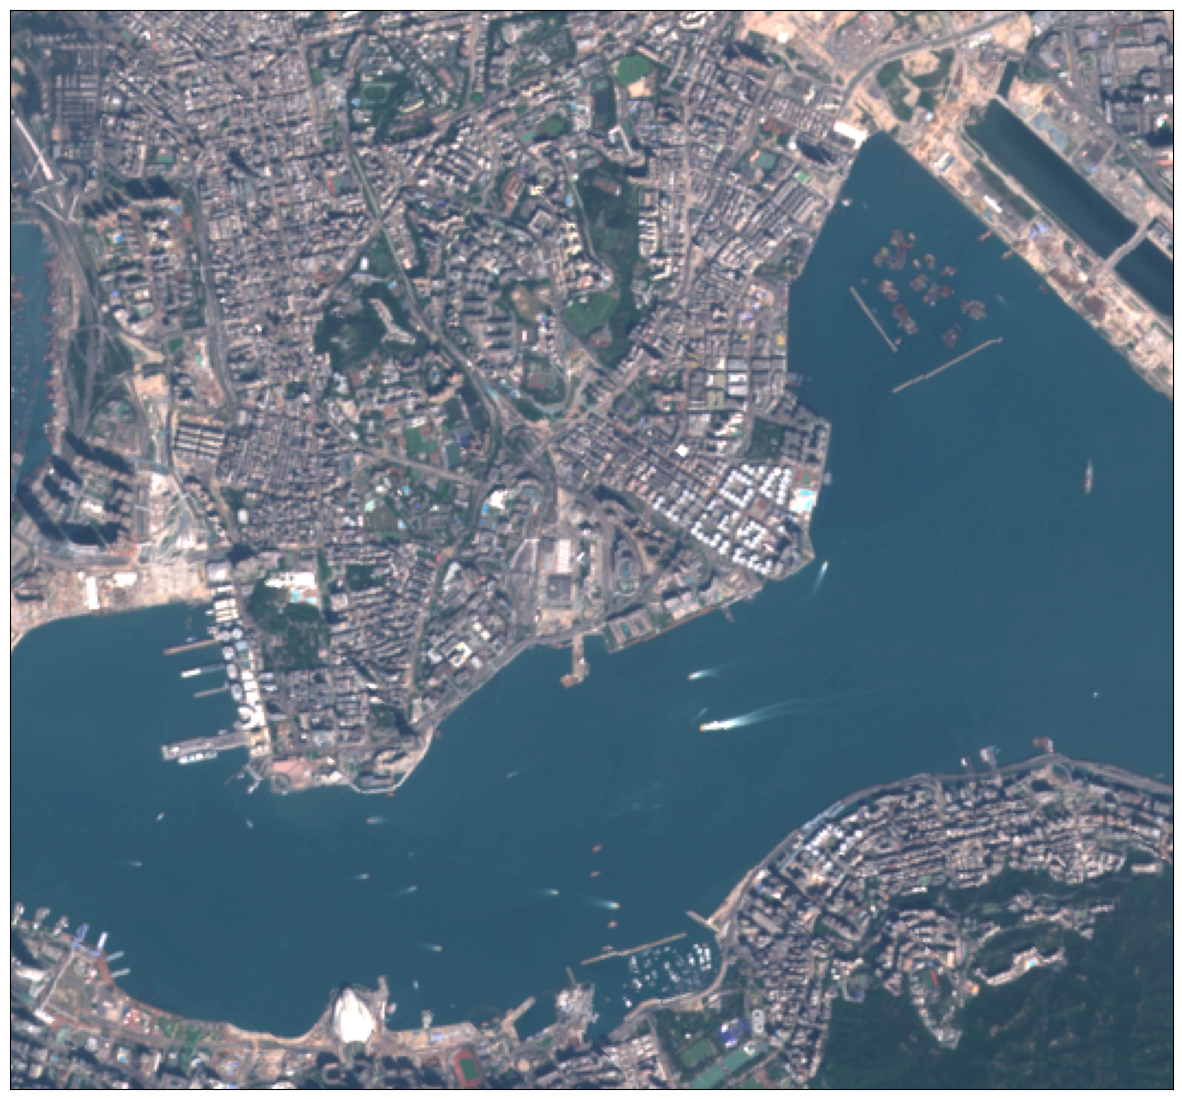

In [10]:
### Block 9
image = true_img[0]
print(f"Image type: {image.dtype}")

# plot function
# factor 1/255 to scale between 0-1
# factor 3.5 to increase brightness
plot_image(image, factor=3.5 / 255, clip_range=(0, 1))

Another example for the Yolo Bypass 

In [4]:
## Block 10
aoi_coords_wgs84 = [-121.699, 38.172, -121.554, 38.374]  ## part of Yolo Bypass
aoi_bbox = BBox(bbox=aoi_coords_wgs84, crs=CRS.WGS84)


In [7]:
## Block 11
## First define evalscript, which includes the formula for calculating AWEIsh (Automated Water Extraction Index with shadow),
## an index used for detecting flooding
## Second, make a request for the data based on given area of interest (aoi) defined above and time interval (2018 Oct 1 to 6)
## Notice the difference between this request (SentinelHubRequest) and the one in Block 3 (catalog.search). 
## SentinelHubRequest can get the actual data through the request_awei_img.get_data function (the following command at the end of this block)
## But, catalog.search only tells us the data availability (notice that they return the same data!)

## AWEI Automated Water Extraction Index (AWEI) is useful for mapping flooding extent
## The formula is  B + 2.5 * G - 1.5 * (NIR + SWIR1) - (0.25 * SWIR2) 
evalscript_aweish = """
//VERSION=3
function setup() {
  return {
    input: [{
      bands: [
        "B02",
        "B03",
        "B08",
        "B11",
        "B12",
        "dataMask"
      ]
    }],
    output: {
      bands: 4
    }
  }
}
  
let viz = ColorGradientVisualizer.createWhiteGreen(-1.0, 1.0);

function evaluatePixel(samples) {
    let val = samples.B02 + 2.5 * samples.B03 - (1.5 * (samples.B08 + samples.B11)) - (0.25 * samples.B12)
    val = viz.process(val);
    val.push(samples.dataMask);
    return val;
    
}
"""

request_awei_img = SentinelHubRequest(
    evalscript=evalscript_aweish,   ### calculating AWEIsh
    input_data=[
        SentinelHubRequest.input_data(
            data_collection=DataCollection.SENTINEL2_L2A.define_from(
                name="s2", service_url="https://sh.dataspace.copernicus.eu"
            ),
            #time_interval=("2019-01-19", "2019-01-21"), ## cloudy example
            time_interval=("2018-10-01","2018-10-06"), ## time interval
            mosaicking_order=MosaickingOrder.LEAST_CC   ## ranking using cloud cover 
            #other_args={"dataFilter": {"mosaickingOrder": "leastCC"}},
        )
    ],
    responses=[SentinelHubRequest.output_response("default", MimeType.TIFF)],
    bbox=aoi_bbox,
    size=aoi_size,
    config=config,
)

awei_img = request_awei_img.get_data()
slice_0_raw = awei_img[0][:, :, 0] ## The first data with SFH tile
slice_1_raw = awei_img[0][:, :, 1] ## The second data with SFJ tile

In [13]:
## Block 12
print(
    f"Returned data is of type = {type(awei_img)} and length {len(awei_img)}."
)
print(
    f"Single element in the list is of type {type(awei_img[-1])} and has shape {awei_img[-1].shape}"
)


Returned data is of type = <class 'list'> and length 1.
Single element in the list is of type <class 'numpy.ndarray'> and has shape (493, 531, 4)


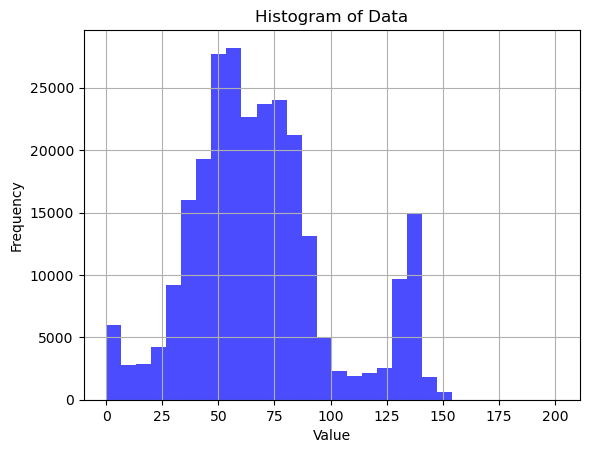

In [14]:
## Block 13
flattened_array = slice_1_raw.flatten()
plt.hist(flattened_array, bins=30, color='blue', alpha=0.7)  # Adjust bins, color, and transparency as needed
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram of Data')
plt.grid(True)
plt.show()

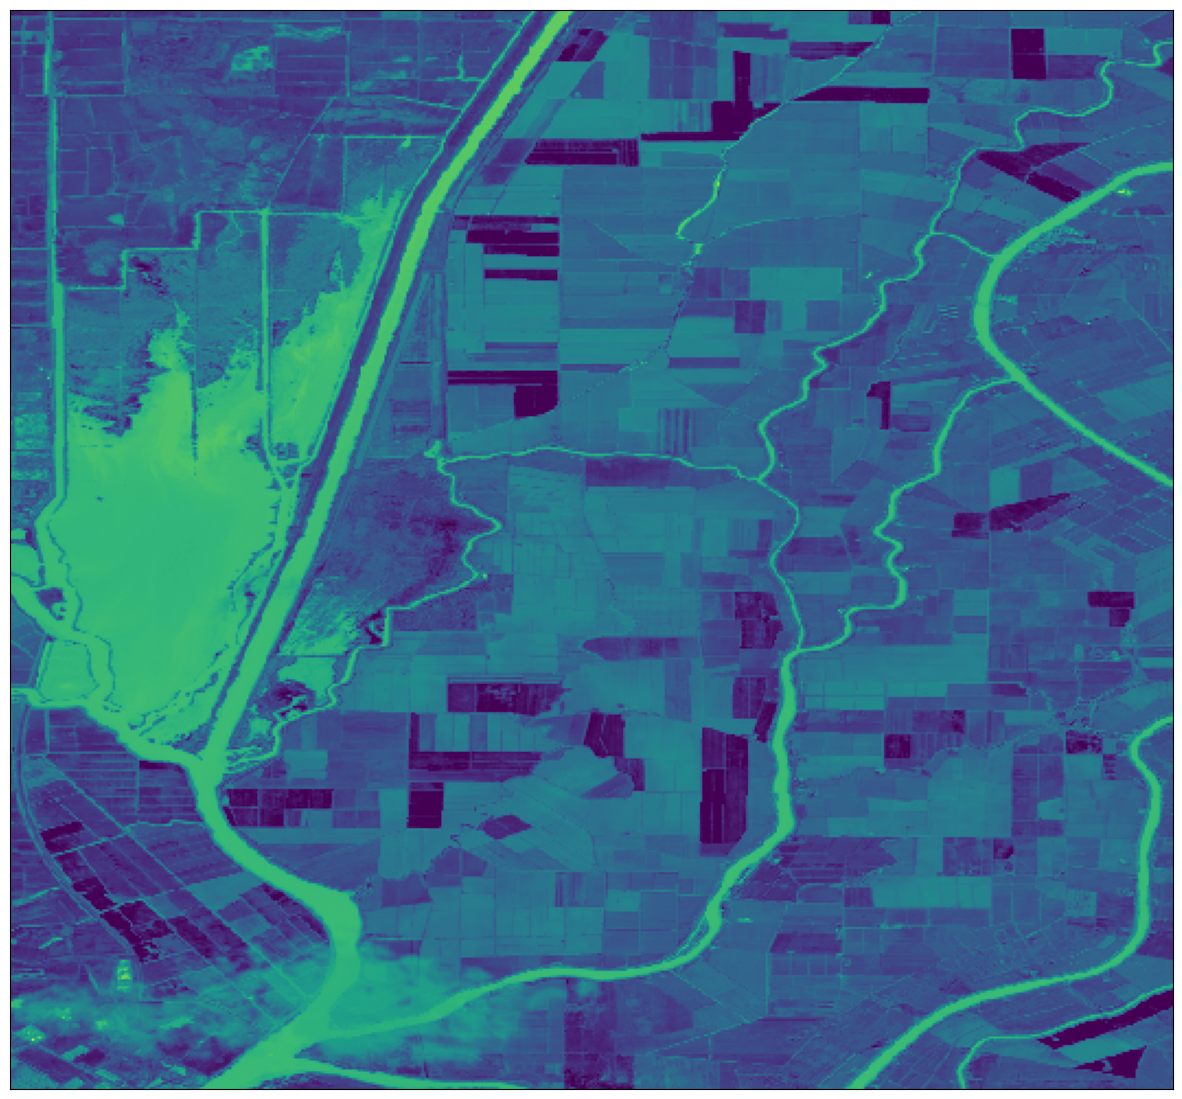

In [15]:
## Block 14
plot_image(slice_1_raw)

Excercise 1

Create a new evalscript to calculate NDVI (Normalized Difference Vegetation Index) 
NDVI = (NIR - RED) / (NIR + RED)

In [ ]:
##### YOUR CODE HERE


Section 5 Get Sentinel-2 time series for a study area

In [8]:
## Block 15
## The main block for obtaining the Sentinel-2 data for an extensive time interval (whatever time span you like!) for the given AOI
## These are the tuning parameters you can play with

## start_date - the starting date of time window of interest
## final_date   - the end date of time window of interest
## region - 1, 2, 3, representing lower, middle and upper Yolo Bypass

start_date = "2018-10-01"
end_date = start_date
final_date = "2019-03-01" ### In this experiments, we deal with 2018 water year which ends 2019 October
data_collection = "SENTINEL-2"
region = 1 ## region 1 is lower part of Yolo bypass, 2 is middle, 3 is upper
fullreg = (-121.699, 38.172, -121.554, 38.778) ## full region used for search_iterator
fullreg_bbox = BBox(bbox=fullreg, crs=CRS.WGS84)
fullreg_size = bbox_to_dimensions(fullreg_bbox, resolution=10)
########### Subregions for request because of limitation in latitude##########
if region == 1:
    betsiboka_coords_wgs84 = (-121.699, 38.172, -121.554, 38.374) ## lower
    reg = 'Lower'
elif region == 3:
    betsiboka_coords_wgs84 = (-121.699, 38.374, -121.554, 38.576) ## middle
    reg = 'Middle'
else:
    betsiboka_coords_wgs84 = (-121.699, 38.576, -121.554, 38.778) ## upper
    reg = 'Upper'

betsiboka_bbox = BBox(bbox=betsiboka_coords_wgs84, crs=CRS.WGS84)
betsiboka_size = bbox_to_dimensions(betsiboka_bbox, resolution=10)


final_datetime = datetime.strptime(final_date, "%Y-%m-%d")  ## datetime format for final_date variable

loop = 0  ### the number of loops for the while loop below
end_datetime = datetime.strptime(end_date, "%Y-%m-%d") ## datetime format for end_date

ct = 0  ### number of S-2 acquisitions 
dates_ary = [] ### recording the data acquisition time for the time series 
time_difference = dt.timedelta(hours=1)


In [9]:
## Block 16 - while loop to get all S-2 time series in the given time window

## These are the tuning parameters you can play with
## tiletoremove - If you know a certain tile you do not want, in this case SEH, list here the program will not download that one
## prefix - If you want to save the raster images, prefix should be your path
## prefix - for example, prefix = r'D:\Paul\Groundwater\Code\\'
## Towards the end of this block, the command awei_img = request_awei_img.get_data(save_data=True) ## get the data.
## Consider uses this if you do not want to download the data: request_awei_img.get_data()
## The last two lines save all the data (if you spans it two a full year, it will be over 2GB!)


## Run it and have fun!!!

tiletoremove = "SEH"
while end_datetime <= final_datetime:
    print("Loop Number is:")
    print(loop)
    time_datetime = datetime.strptime(start_date, "%Y-%m-%d") ## datetime format for start date
    # Add 20 days to the datetime object
    time_after_10_days = time_datetime + timedelta(days=10) ## make every 10 days an interval because the limitation of number of images per request
    end_date = time_after_10_days.strftime("%Y-%m-%d") ## string format for end date
    
    
    catalog = SentinelHubCatalog(config=config) ## initiate a new catalog for data searching.
    time_interval = start_date, end_date ## time interval of the 10 days
    search_iterator = catalog.search(
        DataCollection.SENTINEL2_L2A,
        bbox=fullreg_bbox, ## using the full range instead of part of it. 
        time=time_interval,
        #filter="eo:cloud_cover < 20", ## adding cloud coverage condition
        fields={"include": ["id", "properties.datetime"], "exclude": []},
    )  ##  search how many images within this periof of 10 days
    
    rawresults = list(search_iterator)
    indices_without_SEH = [index for index, item in enumerate(rawresults) if tiletoremove not in item['id']]
    all_timestamps = search_iterator.get_timestamps()
    tempstamp = np.array(all_timestamps)
    temp = np.array(rawresults)
    results = temp[np.array(indices_without_SEH).astype(int)]
    all_timestamps = tempstamp[np.array(indices_without_SEH).astype(int)]
    tile = [item['id'][38:44] for item in results]
    time = [dt.strftime("%Y-%m-%d") for dt in all_timestamps]
    cuts = [d + t for d, t in zip(time, tile)]
    # Append strings one by one
    for string in cuts:
        dates_ary.append(string)  ## append to dates_ary which records the dates for the entire water year
     
    #prefix = r'D:\Paul\Groundwater\Code\\' ## An example
    prefix = '' ## If you leave it like this, it will download the data at the current folder in use (and you can start with this).

    # Adding the prefix to each string in the array
    
    datesnew = [f"{prefix}{reg}\\{s}_{i}\\" for i, s in enumerate(cuts)] ## generates a folder name.
    print("Total number of results:", len(results))
    print("start date is ")
    print(start_date)
    print("end date is ")
    print(end_date) ## print info out for checking. 
    
    if len(results) == 0:
        
        start_date = time_after_10_days.strftime("%Y-%m-%d") ## string format for start date, replace with end time
        end_datetime = datetime.strptime(end_date, "%Y-%m-%d") ## datetime for end time 
        loop = loop + 1
        continue
    else:
        for i in range(len(results)): ## this for loop is for every images within the 10 days period
            print(datesnew[i]) ## this is the folder directory 
            request_awei_img = SentinelHubRequest(  ## request configuaration
            data_folder = datesnew[i], ## folder to save tiff data
            evalscript=evalscript_aweish, ## used the evalscript_aweish defined above
            input_data=[
                SentinelHubRequest.input_data(
                    data_collection=DataCollection.SENTINEL2_L2A.define_from(
                        name="s2", service_url="https://sh.dataspace.copernicus.eu"
                    ),
                    time_interval=(all_timestamps[i] - time_difference, all_timestamps[i] + time_difference),
                    mosaicking_order=MosaickingOrder.LEAST_CC,
                    #other_args={"dataFilter": {"mosaickingOrder": "leastCC"}},
                )
            ],
            responses=[SentinelHubRequest.output_response("default", MimeType.TIFF)],
            bbox=betsiboka_bbox,
            size=betsiboka_size,
            config=config,
            )
            awei_img = request_awei_img.get_data(save_data=True) ## get the data. 
            
            temp = np.array(awei_img[0][:, :, i]) ## for ith image, get the AWEIsh values
            if ct == 0:
                alldata = np.empty((temp.shape[0], temp.shape[1], 1)) ## if the first one in the first while loop, create alldata array which stores all the image values!
                alldata[:, :, 0] = temp ## make the values in temp as the first image in alldata. The rest of the time series will be stacked in this 3-d array
                ct = ct + 1
            else:
                alldata = np.concatenate((alldata, temp[:, :, np.newaxis]), axis=2) ## if not the first one, append on alldata.
                ct = ct + 1
        start_date = time_after_10_days.strftime("%Y-%m-%d") ## update start_date as the end_date
        end_datetime = datetime.strptime(end_date, "%Y-%m-%d") ## update end_datetime        
        loop = loop + 1 ## increase loop number

########################### save the image values #############################
fname = 'wateryear2018' + reg + '.npy'
np.save(fname, alldata)

Loop Number is:
0
Total number of results: 2
start date is 
2018-10-01
end date is 
2018-10-11
Lower\2018-10-02T10SFH_0\
Lower\2018-10-02T10SFJ_1\
Loop Number is:
1
Total number of results: 0
start date is 
2018-10-11
end date is 
2018-10-21
Loop Number is:
2
Total number of results: 2
start date is 
2018-10-21
end date is 
2018-10-31
Lower\2018-10-22T10SFH_0\
Lower\2018-10-22T10SFJ_1\
Loop Number is:
3
Total number of results: 0
start date is 
2018-10-31
end date is 
2018-11-10
Loop Number is:
4
Total number of results: 0
start date is 
2018-11-10
end date is 
2018-11-20
Loop Number is:
5
Total number of results: 0
start date is 
2018-11-20
end date is 
2018-11-30
Loop Number is:
6
Total number of results: 0
start date is 
2018-11-30
end date is 
2018-12-10
Loop Number is:
7
Total number of results: 0
start date is 
2018-12-10
end date is 
2018-12-20
Loop Number is:
8
Total number of results: 1
start date is 
2018-12-20
end date is 
2018-12-30
Lower\2018-12-26T10SFH_0\
Loop Number is:

Each loop represents a 10-day interval. We have to split the requests in different time intervals due to limitation from Copernicus to obtain data from one request.

Let's check some important parameters for post-processing

In [19]:
## Block 17
## Check how many images were obtained

ct 

18

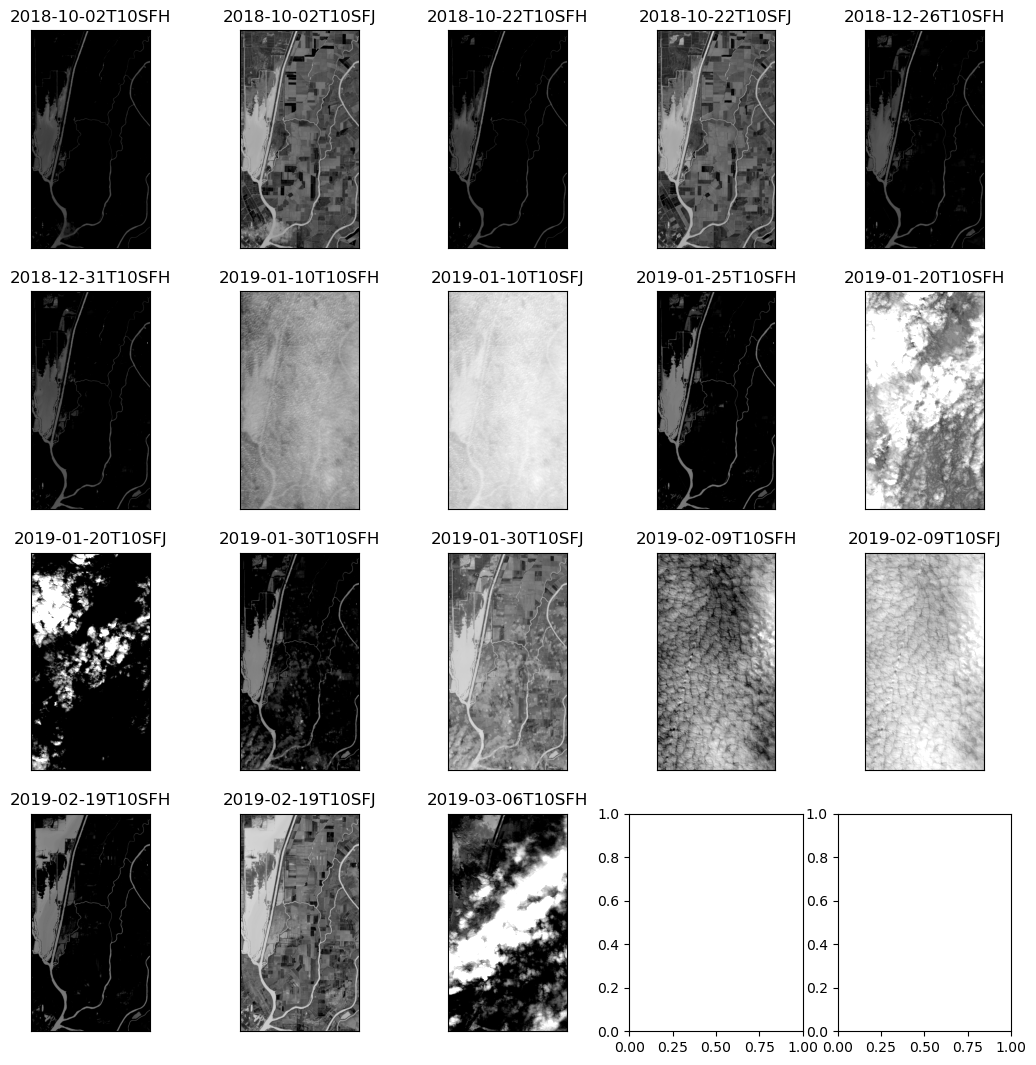

In [20]:
### Block 18
### Visualize all images 

## Since there are 10 images in total, we plot the images 4 by 5 as below
## The key is to make num_rows * num_cols > ct 

num_rows = 4
num_cols = 5

fig, axes = plt.subplots(num_rows, num_cols, figsize=(13, 13))

# Iterate through each image
for i in range(alldata.shape[2]):
    # Plot the image
    row_idx = i // num_cols
    col_idx = i % num_cols

    # Plot the image on the current axis
    im = axes[row_idx, col_idx].imshow(alldata[:, :, i], cmap='gray', vmin=0, vmax=200)  # assuming grayscale images
   
    #axes[row_idx, col_idx].set_title(f'Image {i+1}', fontsize = 4)
    axes[row_idx, col_idx].set_title(dates_ary[i], fontsize =12)
    axes[row_idx, col_idx].set_xticks([])
    axes[row_idx, col_idx].set_yticks([])

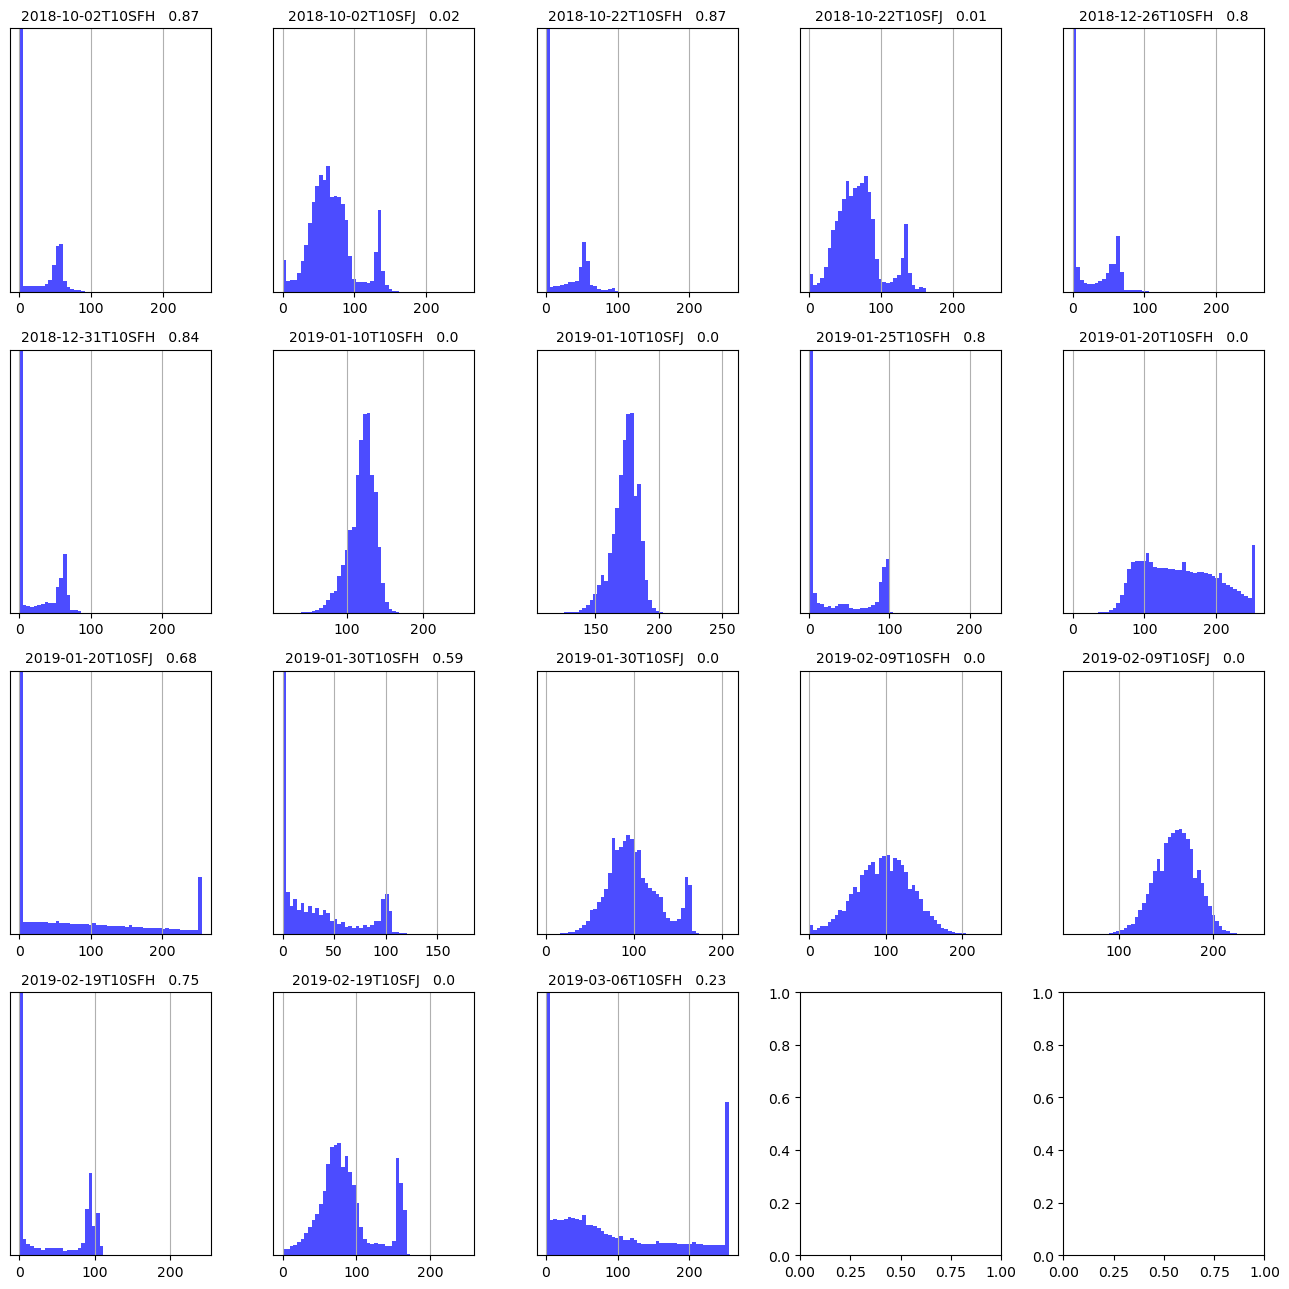

There are this number of qualified images (less than 25% of 0s)


10

In [11]:
## Block 19
## Histogram analysis
## Make a same num_cols and num_rows
## filter the images with a criteria with the percentage of 0 (perc variable calculated below)
num_rows = 4
num_cols = 5
flag = np.zeros(alldata.shape[2])
zerothd = 0.50 ## meaning if over 75% of zeros, we remove the image 
fig, axes = plt.subplots(num_rows, num_cols, figsize=(13, 13))

# Plot histograms in each subplot
for i in range(alldata.shape[2]):
    row_idx = i // num_cols
    col_idx = i % num_cols
    flattened_array = alldata[:, :, i].flatten()
    axes[row_idx, col_idx].hist(flattened_array, bins=50, color='blue', alpha=0.7)
    axes[row_idx, col_idx].set_title(f'Image {i+1}', fontsize = 6)
    #axes[row_idx, col_idx].set_xticks([])
    axes[row_idx, col_idx].set_yticks([])
    axes[row_idx, col_idx].grid(True)
    axes[row_idx, col_idx].set_ylim(0, 500000) 
    
    perc = np.round(len(np.where(flattened_array == 0)[0]) / len(flattened_array), 2)
    axes[row_idx, col_idx].set_title(dates_ary[i] + '   ' + str(perc), fontsize = 10)
    flag[i] = 0 if perc > zerothd else 1
plt.tight_layout()
plt.show()

print("There are this number of qualified images (less than 25% of 0s)")
len(np.where(flag == 1)[0])

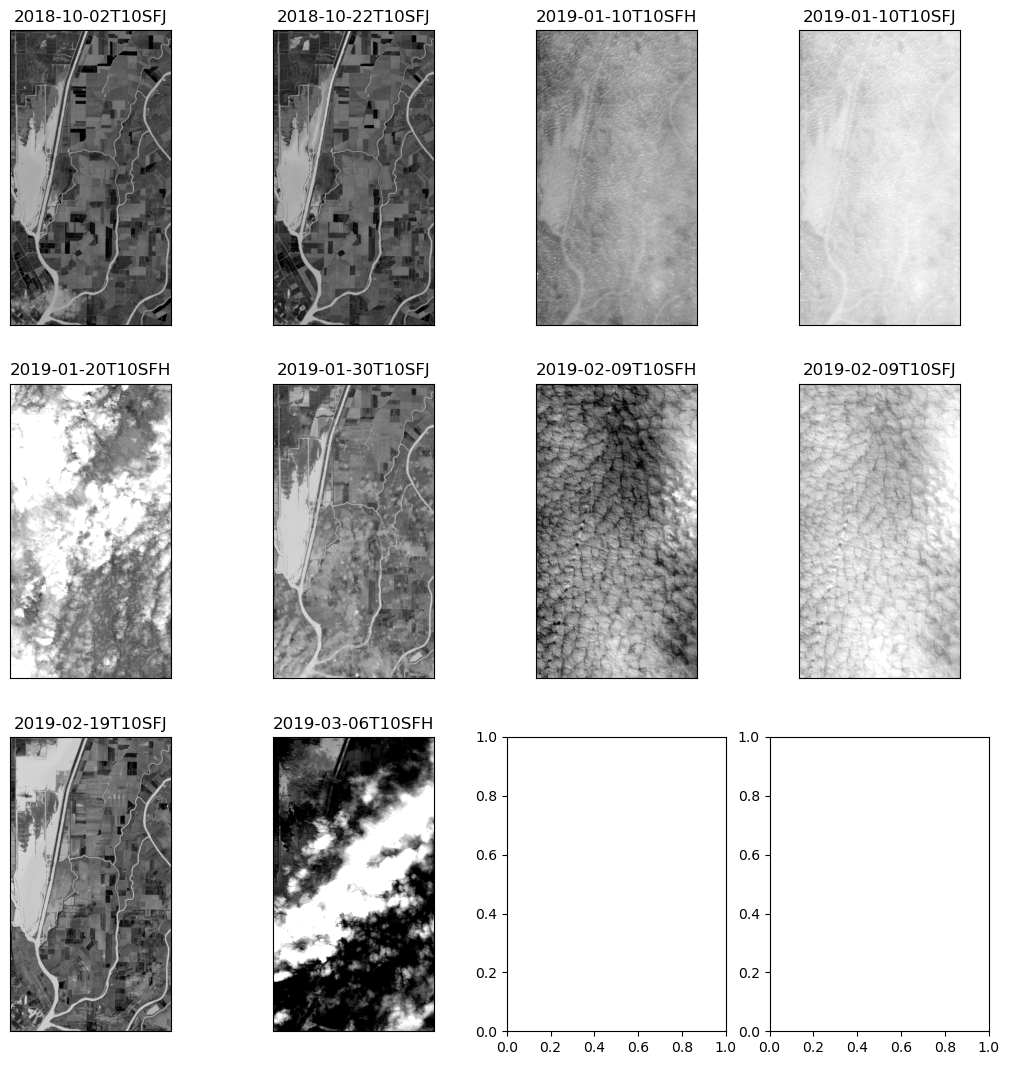

In [22]:
## Block 20
## Replot only the qualified images

num_rows = 3
num_cols = 4

fig, axes = plt.subplots(num_rows, num_cols, figsize=(13, 13))
index = np.where(flag == 1)[0]
# Iterate through each image
for i in range(len(np.where(flag == 1)[0])): ## the number of qualified images
    
    # Plot the image
    row_idx = i // num_cols
    col_idx = i % num_cols

    # Plot the image on the current axis
    im = axes[row_idx, col_idx].imshow(alldata[:, :, index[i]], cmap='gray', vmin=0, vmax=200)  # assuming grayscale images
   
    #axes[row_idx, col_idx].set_title(f'Image {i+1}', fontsize = 4)
    axes[row_idx, col_idx].set_title(dates_ary[index[i]], fontsize =12)
    axes[row_idx, col_idx].set_xticks([])
    axes[row_idx, col_idx].set_yticks([])

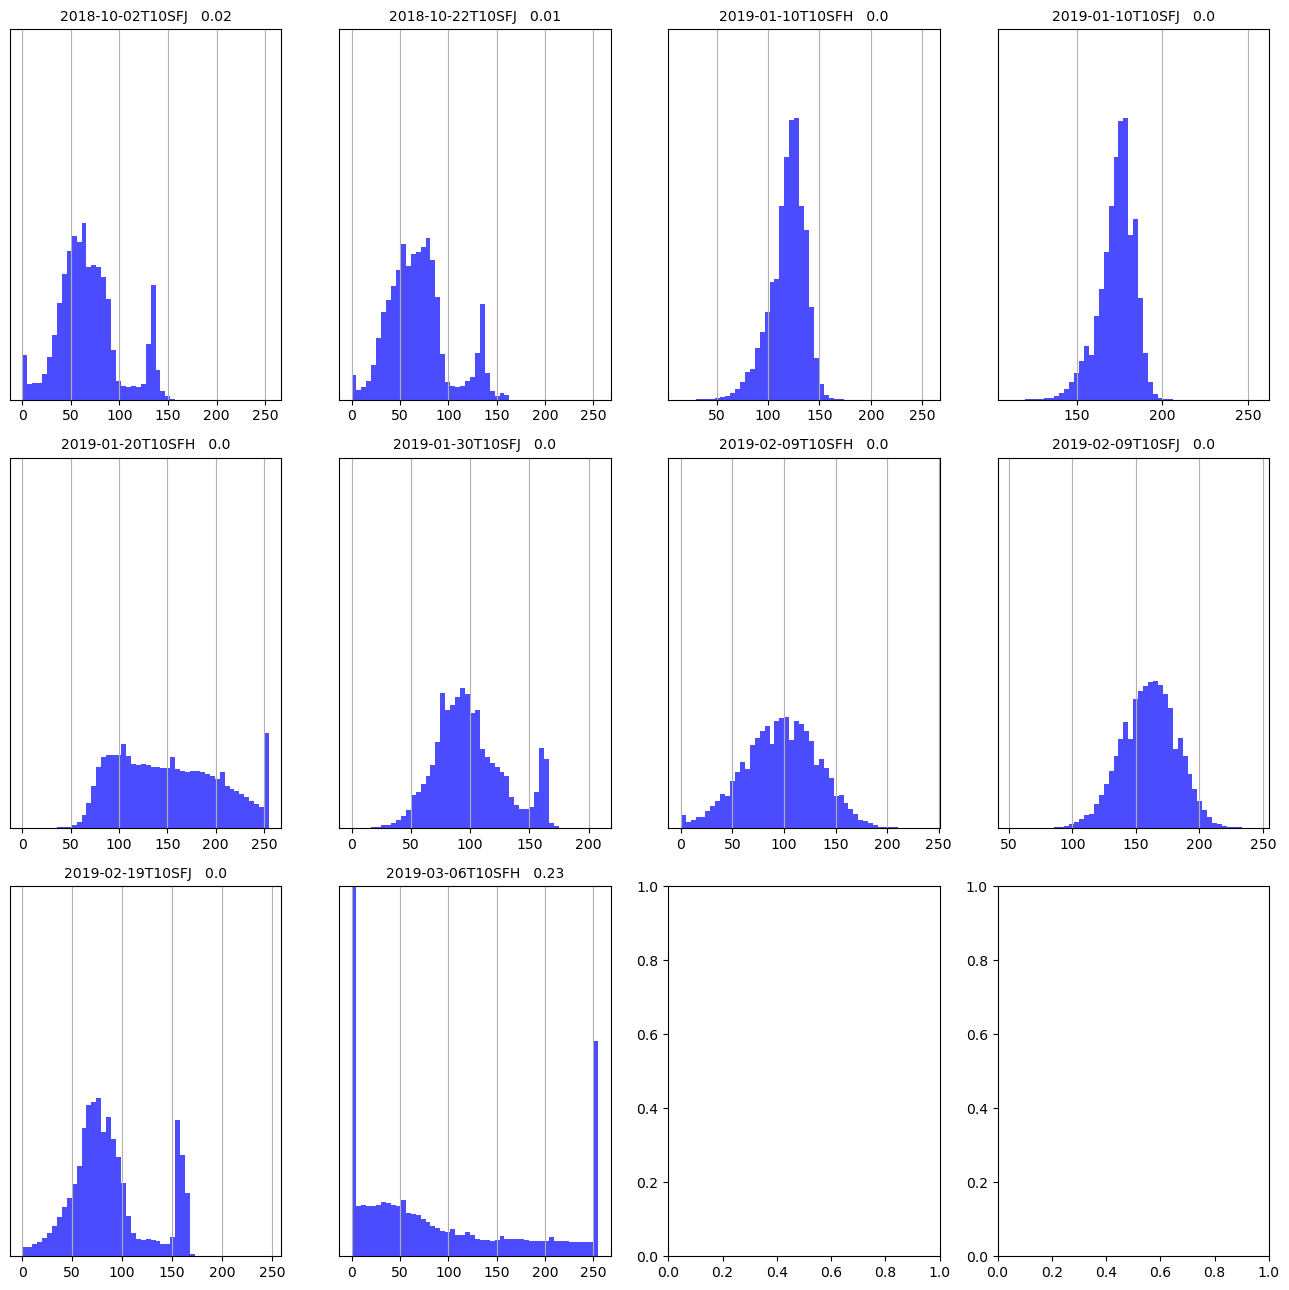

In [23]:
## Block 21
## Replot only the qualified images

num_rows = 3
num_cols = 4

fig, axes = plt.subplots(num_rows, num_cols, figsize=(13, 13))
index = np.where(flag == 1)[0]

for i in range(len(np.where(flag == 1)[0])):
    row_idx = i // num_cols
    col_idx = i % num_cols
    flattened_array = alldata[:, :, index[i]].flatten()
    axes[row_idx, col_idx].hist(flattened_array, bins=50, color='blue', alpha=0.7)
    axes[row_idx, col_idx].set_title(f'Image {i+1}', fontsize = 6)
    #axes[row_idx, col_idx].set_xticks([])
    axes[row_idx, col_idx].set_yticks([])
    axes[row_idx, col_idx].grid(True)
    axes[row_idx, col_idx].set_ylim(0, 500000) 
    
    perc = np.round(len(np.where(flattened_array == 0)[0]) / len(flattened_array), 2)
    axes[row_idx, col_idx].set_title(dates_ary[index[i]] + '   ' + str(perc), fontsize = 10)
plt.tight_layout()
plt.show()

Section 6 Cloud masking with s2cloudless 

Congrats if you make it to the final step!

This section we do cloud masking using s2cloudless package and then plot time series at a pixel scale. 

In [14]:
### Block 22
### Cloud mask with s2cloudless package
### Note here we use L1C data to get data mask
### Use this block to generate a evalscript for all bands
data_collection = DataCollection.SENTINEL2_L1C
evalscript = generate_evalscript(
    data_collection=data_collection,
    meta_bands=["dataMask"],
    merged_bands_output="bands",
    prioritize_dn=False,
)

print(evalscript)



//VERSION=3

function setup() {
    return {
        input: [{
            bands: ["B01", "B02", "B03", "B04", "B05", "B06", "B07", "B08", "B8A", "B09", "B10", "B11", "B12", "dataMask"],
            units: ["REFLECTANCE", "REFLECTANCE", "REFLECTANCE", "REFLECTANCE", "REFLECTANCE", "REFLECTANCE", "REFLECTANCE", "REFLECTANCE", "REFLECTANCE", "REFLECTANCE", "REFLECTANCE", "REFLECTANCE", "REFLECTANCE", "DN"]
        }],
        output: [{id: "bands", bands: 13, sampleType: "FLOAT32"}, {id: "dataMask", bands: 1, sampleType: "UINT8"}]
    }
}

function updateOutputMetadata(scenes, inputMetadata, outputMetadata) {
    outputMetadata.userData = {
        "norm_factor":  inputMetadata.normalizationFactor
    }
}

function evaluatePixel(sample) {
    return { bands: [sample.B01, sample.B02, sample.B03, sample.B04, sample.B05, sample.B06, sample.B07, sample.B08, sample.B8A, sample.B09, sample.B10, sample.B11, sample.B12], dataMask: [sample.dataMask] };
}



In [25]:
### Block 23
### Obtain all bands for one image (2019-03-06) with a lot of cloud

request = SentinelHubRequest(
    evalscript=evalscript,
    input_data=[SentinelHubRequest.input_data(data_collection=DataCollection.SENTINEL2_L1C.define_from("s2l1c", service_url=config.sh_base_url), time_interval="2019-03-06")],
    responses=[
        SentinelHubRequest.output_response("bands", MimeType.TIFF),
        SentinelHubRequest.output_response("dataMask", MimeType.TIFF),
    ],
    bbox=betsiboka_bbox,
    size=betsiboka_size,
    config=config,
)

data = request.get_data()[0]

bands = data["bands.tif"]
mask = data["dataMask.tif"]


bands.shape, mask.shape

((2260, 1235, 13), (2260, 1235))

In [27]:
### Block 24
### Uses s2cloudless algorithms to calculate cloud_mask and cloud_probability as below

cloud_detector = S2PixelCloudDetector(threshold=0.4, average_over=4, dilation_size=2, all_bands=True)
cloud_mask = cloud_detector.get_cloud_masks(bands[np.newaxis, ...])
cloud_prob = cloud_detector.get_cloud_probability_maps(bands[np.newaxis, ...])

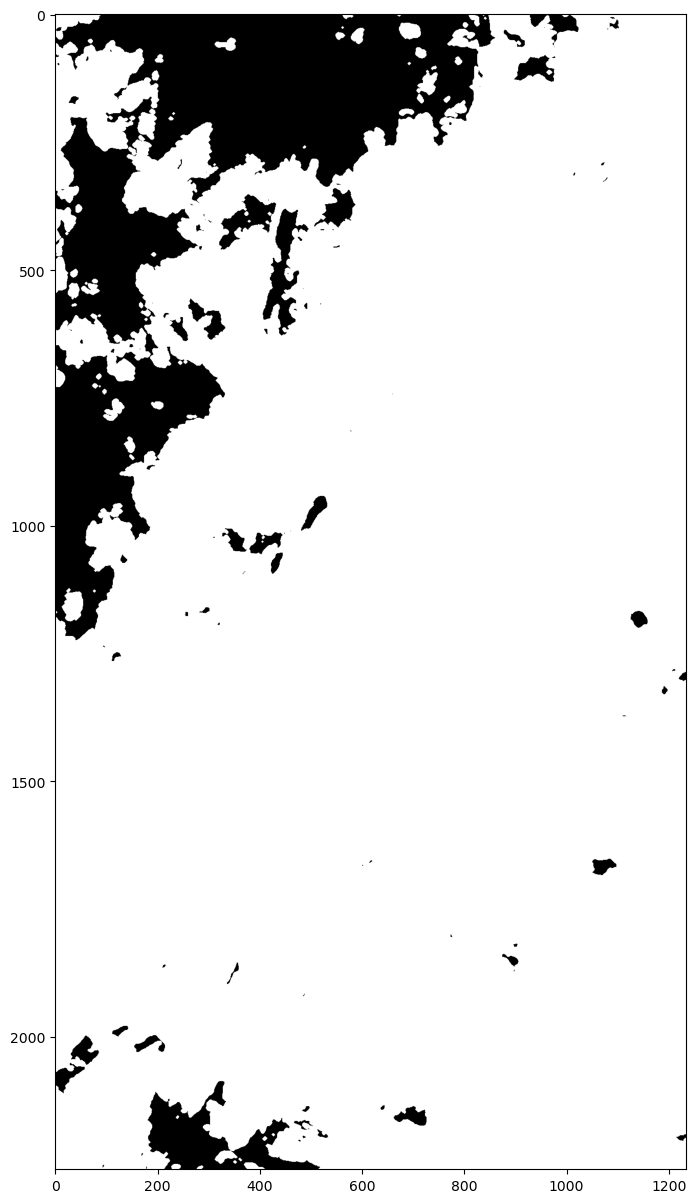

In [28]:
### Block 25
## Plot the cloud mask
## White is cloud
## Dark is no-cloud
plt.figure(figsize=(15, 15))
plt.imshow(cloud_mask[0], cmap=plt.cm.gray)
#plt.imshow(cloud_mask[0], cmap='binary', interpolation='nearest')

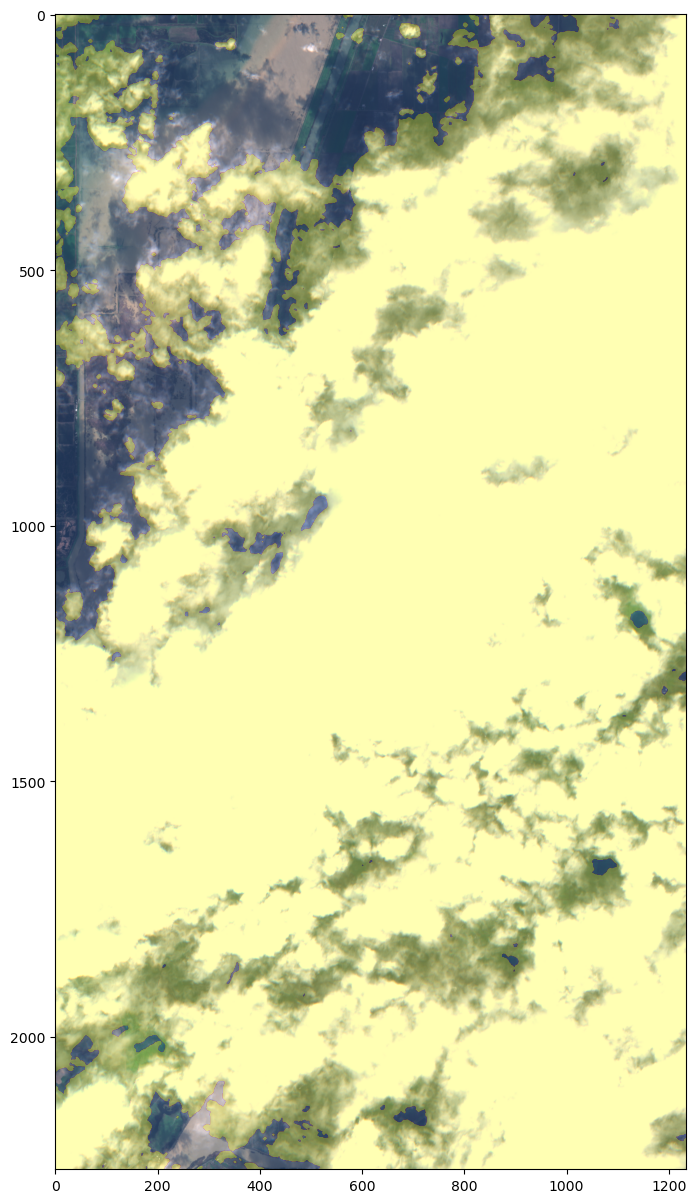

In [29]:
### Block 26
### Another plot - cloud in yellowish color
true_color_image = (bands[..., [3, 2, 1]] * 3.5).clip(0, 1)
is_cloud = cloud_mask[0]

_, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 15))
ax.imshow(true_color_image)
ax.imshow(is_cloud, cmap="gnuplot", alpha=0.3 * is_cloud)

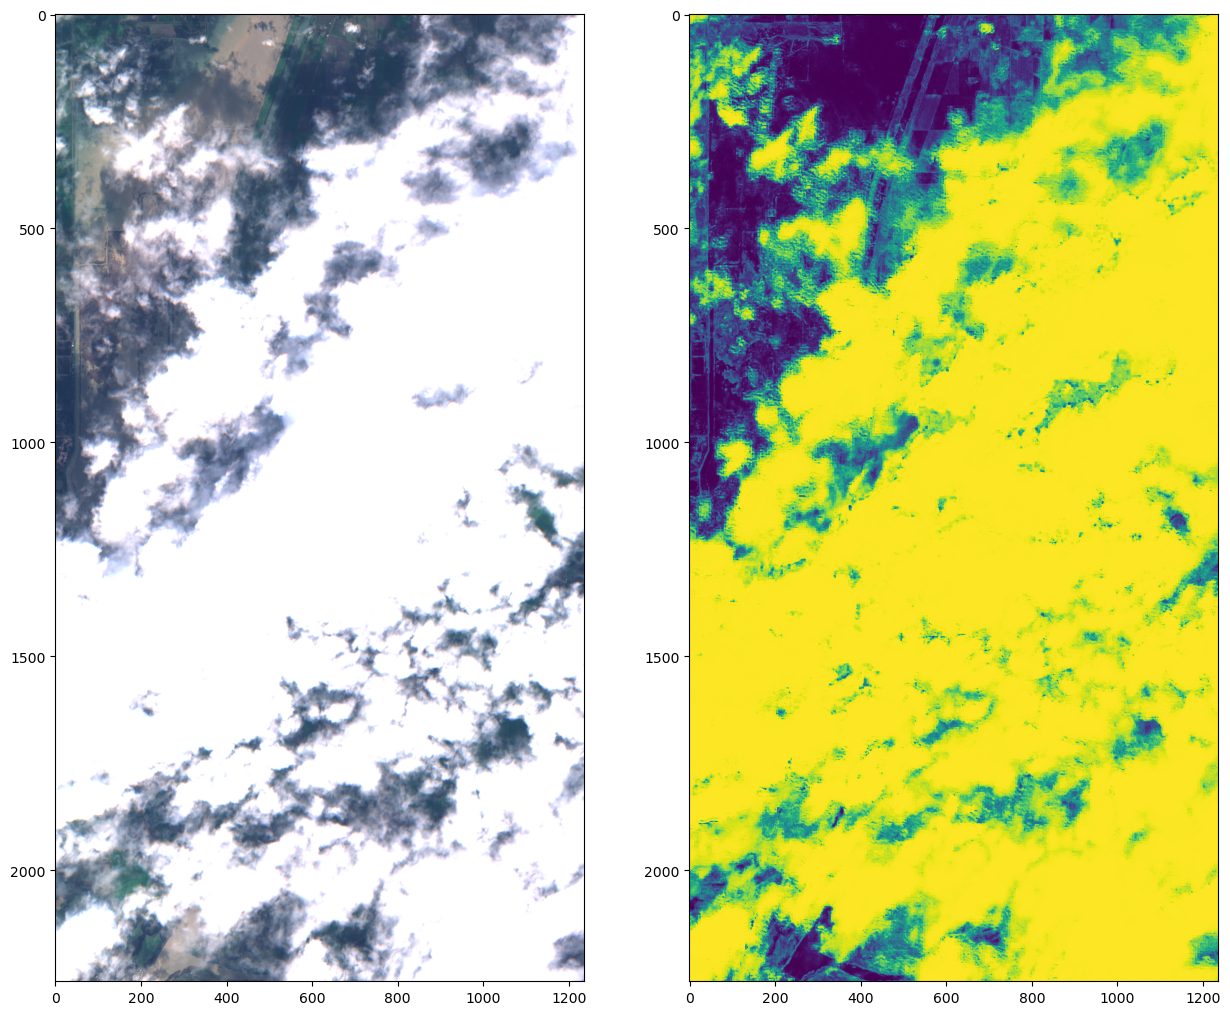

In [30]:
### Block 27
### Mapping cloud probability, comparing with true color
_, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 15))
ax[0].imshow(true_color_image)
ax[1].imshow(cloud_prob[0])

Let's make cloud mask for all qualified images obtained in the previous section
 
We may need to clean up some memory otherwise the script gets stuck because of lack of memory
Notice the command "del alldata" in the next block

In [31]:
### Block 28
### check for your variables' size to select which to delete
# Get a list of variables in the current notebook namespace
variables = list(globals().keys())

# Calculate the size of each variable
variable_sizes = {var: sys.getsizeof(globals()[var]) for var in variables}

# Sort the variables based on their size in decreasing order
sorted_variables = sorted(variable_sizes.items(), key=lambda x: x[1], reverse=True)

# Print the variables along with their sizes
for var, size in sorted_variables:
    print(f"{var}: {size} bytes")

alldata: 401918544 bytes
bands: 145137344 bytes
true_color_image: 33493344 bytes
flattened_array: 22328912 bytes
cloud_prob: 11164544 bytes
cloud_mask: 2791244 bytes
temp: 2791228 bytes
mask: 2791228 bytes
image: 785493 bytes
_i17: 5655 bytes
_i12: 2353 bytes
_i2: 2038 bytes
_i16: 1838 bytes
SHConfig: 1688 bytes
DataCollection: 1688 bytes
SentinelHubCatalog: 1688 bytes
SentinelHubRequest: 1688 bytes
BBox: 1688 bytes
CRS: 1688 bytes
MimeType: 1688 bytes
Geometry: 1688 bytes
MosaickingOrder: 1688 bytes
BackendApplicationClient: 1688 bytes
OAuth2Session: 1688 bytes
S2PixelCloudDetector: 1688 bytes
_i21: 1250 bytes
_i26: 1185 bytes
_i1: 1175 bytes
evalscript: 1008 bytes
_i8: 967 bytes
_i23: 910 bytes
_i20: 821 bytes
_i22: 801 bytes
_i4: 792 bytes
_i3: 748 bytes
_i25: 706 bytes
evalscript_aweish: 563 bytes
_i31: 518 bytes
_i24: 432 bytes
datetime: 424 bytes
timedelta: 424 bytes
_i7: 421 bytes
_i27: 398 bytes
evalscript_true_color: 365 bytes
_oh: 352 bytes
Out: 352 bytes
_ii: 334 bytes
_i29:

we need to delete alldata and bands in the next step

In [12]:
### Block 28
### Create a new matrix, awei_data, for the filtered data
### NOTICE THAT del comes after the first command. Otherwise you won't be able to get awei_data
### You won't be able to run this block the second time because alldata is already gone. You ran into errors if do so. 
awei_data = alldata[:, :, np.where(flag == 1)[0]] ## only qualified S2 images
del alldata, bands, true_color_image, flattened_array, cloud_prob, cloud_mask
awei_filter = np.zeros(awei_data.shape)
valid = np.where(flag == 1)
valid = np.array(valid).flatten()
dates = [datetime.strptime(date_str.split('T')[0], "%Y-%m-%d") for date_str in dates_ary]
extracted_dates = [dates[i] for i in valid]
cloud_detector = S2PixelCloudDetector(threshold=0.4, average_over=4, dilation_size=2, all_bands=True)

In [15]:
## Block 29
## Cloud mask all qualified images
## This step is time consuming because it requests ALL BANDS for each S-2 image
for i in range(len(extracted_dates)):
    print(i)
    tv  = extracted_dates[i].strftime("%Y-%m-%d")
    request = SentinelHubRequest(
    evalscript=evalscript,
    input_data=[SentinelHubRequest.input_data(data_collection=DataCollection.SENTINEL2_L1C.define_from("s2l1c", service_url=config.sh_base_url), time_interval=tv)],
    responses=[
        SentinelHubRequest.output_response("bands", MimeType.TIFF),
        SentinelHubRequest.output_response("dataMask", MimeType.TIFF),
    ],
    bbox=betsiboka_bbox,
    size=betsiboka_size,
    config=config,
    )

    data = request.get_data()[0]

    bands = data["bands.tif"]
    mask = data["dataMask.tif"]
    
    cloud_mask = cloud_detector.get_cloud_masks(bands[np.newaxis, ...])
    is_cloud = cloud_mask[0]
    nocloud = 1 - is_cloud
    awei_filter[:, :, i] = awei_data[:, :, i] * nocloud
    # Create matrix C by element-wise multiplication
    

0
1
2
3
4
5
6
7
8
9


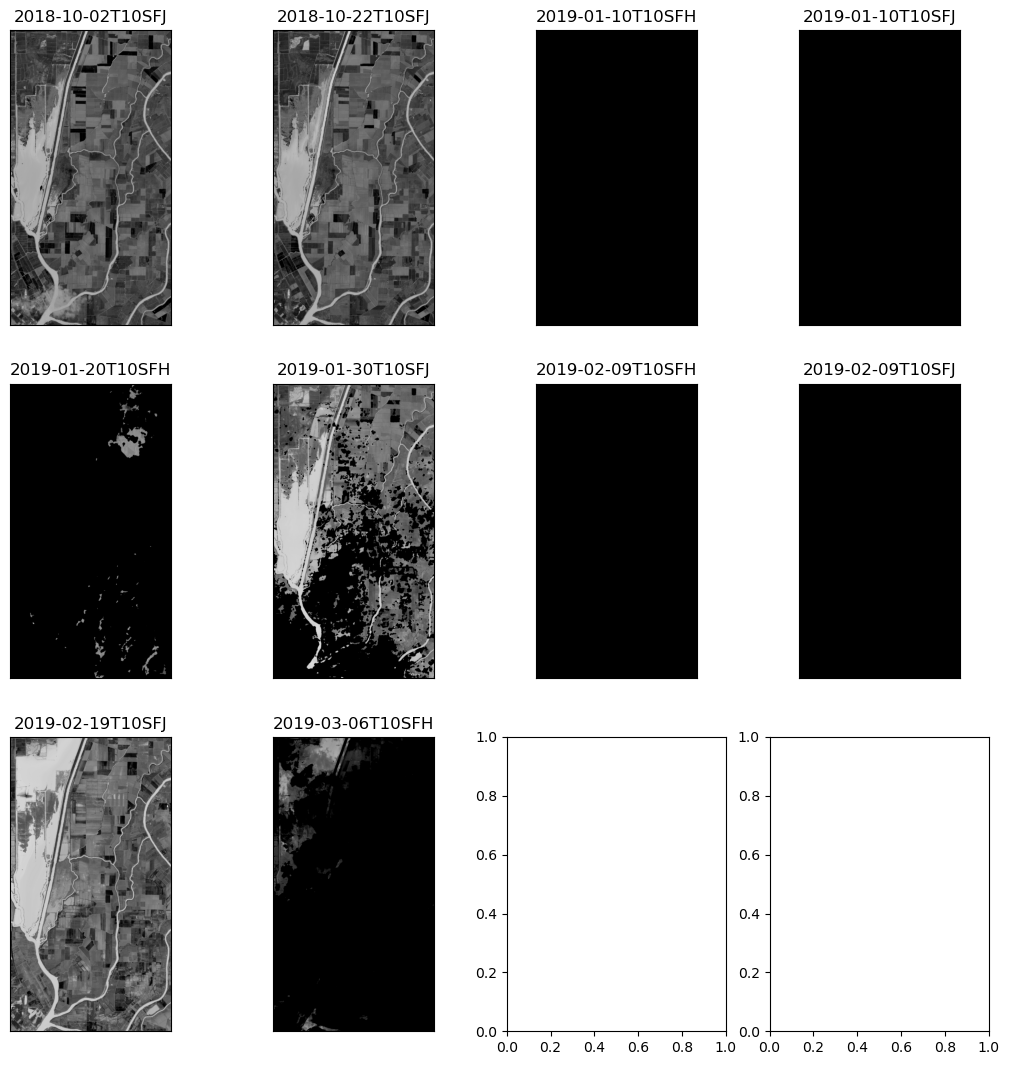

In [21]:
## Block 30
## Replot only the qualified and filtered images

num_rows = 3
num_cols = 4

fig, axes = plt.subplots(num_rows, num_cols, figsize=(13, 13))
index = np.where(flag == 1)[0]

for i in range(len(np.where(flag == 1)[0])): ## the number of qualified images
    
    # Plot the image
    row_idx = i // num_cols
    col_idx = i % num_cols

    # Plot the image on the current axis
    im = axes[row_idx, col_idx].imshow(awei_filter[:, :, i], cmap='gray', vmin=0, vmax=200)  # assuming grayscale images
   
    #axes[row_idx, col_idx].set_title(f'Image {i+1}', fontsize = 4)
    axes[row_idx, col_idx].set_title(dates_ary[index[i]], fontsize =12)
    axes[row_idx, col_idx].set_xticks([])
    axes[row_idx, col_idx].set_yticks([])

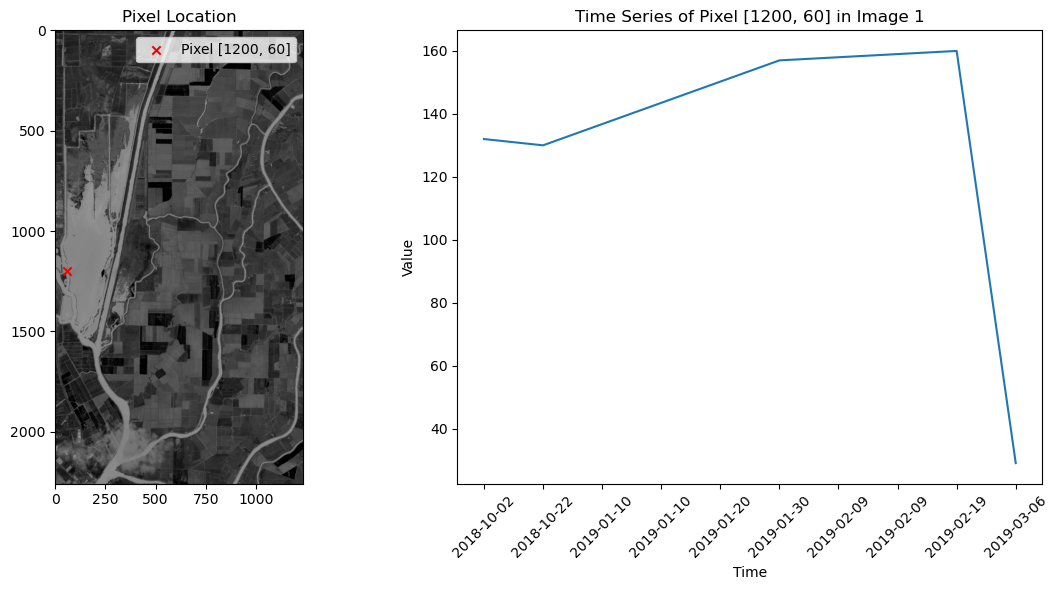

In [22]:
## Block 31
## Draw time series
dt_array = [dt.strftime("%Y-%m-%d") for dt in extracted_dates]

ploc = [1200, 60]
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(awei_filter[:, :, 0], cmap='gray')
axes[0].set_title('Pixel Location')
axes[0].scatter(ploc[1], ploc[0], color='red', marker='x', label='Pixel [1200, 60]')
axes[0].legend()


# Plot the location of the pixel
time_series1 = awei_filter[ploc[0], ploc[1], :]

# Filter out data points where the value is 0
nonzero_indices = np.nonzero(time_series1)
filtered_time_series1 = time_series1[nonzero_indices]


non_zero_time_points = []
non_zero_values = []
for t, v in zip(range(len(extracted_dates)), time_series1):
    if v != 0:
        non_zero_time_points.append(t)
        non_zero_values.append(v)

# Plot the time series of the first image
axes[1].plot(non_zero_time_points, non_zero_values)
axes[1].set_title('Time Series of Pixel [1200, 60] in Image 1')
axes[1].set_xlabel('Time')
axes[1].set_ylabel('Value')
axes[1].set_xticks(np.arange(len(dt_array)))
axes[1].set_xticklabels(dt_array, rotation=45)
# Adjust layout
plt.tight_layout()

plt.show()


Excercise 2

Change time window and AOI for your study area and re-run Section 5 and 6.


That is all!

Hope you find it helpful. Let me know your feedback (bzhang64@ucmerced.edu)!